Link to video explaining the code - https://www.youtube.com/watch?v=XZhPO043lqU



*   https://www.kaggle.com/drscarlat/predict-the-weather-with-fb-prophet
*   additional regressors (at the end, using forecasts of variables to forecast the target to 2030) https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html 
* uncertainty intervals assume that the future will see the same frequency and magnitude of rate changes as the past. This assumption is probably not true, so you should not expect to get accurate coverage on these uncertainty intervals.


In [ ]:
!pip install fbprophet

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os
from datetime import datetime
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
import holidays
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False


In [ ]:
df = pd.read_csv('/content/clean_daily_df_human_logic.csv').dropna()

In [ ]:
df['time']=pd.to_datetime(df['time'],dayfirst=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039 entries, 0 to 2038
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  2039 non-null   datetime64[ns]
 1   MIN_TEMPERATURE_C     2039 non-null   int64         
 2   clients_per_day       2039 non-null   int64         
 3   Holiday_Food_Related  2039 non-null   int64         
 4   consommation          2039 non-null   float64       
 5   pdl_total_daily_load  2039 non-null   int64         
 6   max_pdl_daily_load    2039 non-null   float64       
 7   weekend               2039 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 143.4 KB


In [ ]:
df.head()

,time,MIN_TEMPERATURE_C,clients_per_day,Holiday_Food_Related,consommation,pdl_total_daily_load,max_pdl_daily_load,weekend
0,2015-01-01,8,3970,1,7068.81,16580,1433.0,0
1,2015-01-02,12,3970,0,7074.65,22006,1439.0,0
2,2015-01-03,12,3970,1,7074.65,18629,1127.0,1
3,2015-01-04,15,3971,0,7075.31,18060,1099.0,1
4,2015-01-05,15,3971,0,7083.30,20122,1288.0,0


In [ ]:
ny_df_daily=df.set_index('time')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f717060e290>,
      dtype=object)

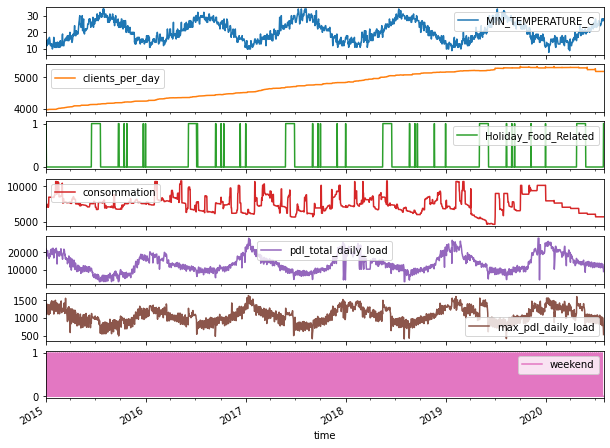

In [ ]:
ny_df_daily.plot(subplots=True)

In [ ]:
from fbprophet import Prophet

In [ ]:
ny_df_daily

,MIN_TEMPERATURE_C,clients_per_day,Holiday_Food_Related,consommation,pdl_total_daily_load,max_pdl_daily_load,weekend
time,,,,,,,
2015-01-01,8,3970,1,7068.81,16580,1433.0,0
2015-01-02,12,3970,0,7074.65,22006,1439.0,0
2015-01-03,12,3970,1,7074.65,18629,1127.0,1
2015-01-04,15,3971,0,7075.31,18060,1099.0,1
2015-01-05,15,3971,0,7083.30,20122,1288.0,0
...,...,...,...,...,...,...,...
2020-07-27,28,5189,0,5719.40,13174,1010.0,0
2020-07-28,28,5189,0,5719.40,13097,986.0,0
2020-07-29,27,5189,0,5719.40,12000,873.0,0


In [ ]:
ny_df_daily.columns

Index(['MIN_TEMPERATURE_C', 'clients_per_day', 'Holiday_Food_Related',
       'consommation', 'pdl_total_daily_load', 'max_pdl_daily_load',
       'weekend'],
      dtype='object')

In [ ]:
ny_df_final=ny_df_daily.reset_index()[['time','MIN_TEMPERATURE_C', 'clients_per_day', 
        'consommation', 'pdl_total_daily_load','weekend', 'max_pdl_daily_load']].rename({'time':'ds',
        'MIN_TEMPERATURE_C':'MIN_TEMPERATURE_C', 'clients_per_day':'clients_per_day',
        'consommation':'consommation','pdl_total_daily_load':'pdl_total_daily_load',
        'weekend':'weekend','max_pdl_daily_load':'y'}, axis='columns')

In [ ]:
ny_df_final

,ds,MIN_TEMPERATURE_C,clients_per_day,consommation,pdl_total_daily_load,weekend,y
0,2015-01-01,8,3970,7068.81,16580,0,1433.0
1,2015-01-02,12,3970,7074.65,22006,0,1439.0
2,2015-01-03,12,3970,7074.65,18629,1,1127.0
3,2015-01-04,15,3971,7075.31,18060,1,1099.0
4,2015-01-05,15,3971,7083.30,20122,0,1288.0
...,...,...,...,...,...,...,...
2034,2020-07-27,28,5189,5719.40,13174,0,1010.0
2035,2020-07-28,28,5189,5719.40,13097,0,986.0
2036,2020-07-29,27,5189,5719.40,12000,0,873.0
2037,2020-07-30,27,5189,5719.40,11604,0,762.0


In [ ]:
train=ny_df_final[ny_df_final['ds'] <= '2019-12-31']
test=ny_df_final[(ny_df_final['ds'] > '2019-12-31')]

In [ ]:
train.shape

(1826, 7)

In [ ]:
test.shape

(213, 7)

In [ ]:
test

,ds,MIN_TEMPERATURE_C,clients_per_day,consommation,pdl_total_daily_load,weekend,y
1826,2020-01-01,11,5339,10167.27,24743,0,1414.0
1827,2020-01-02,12,5313,7966.39,23393,0,1296.0
1828,2020-01-03,12,5313,7966.39,23437,0,1300.0
1829,2020-01-04,12,5313,7966.39,24549,1,1361.0
1830,2020-01-05,14,5313,7966.39,25404,1,1557.0
...,...,...,...,...,...,...,...
2034,2020-07-27,28,5189,5719.40,13174,0,1010.0
2035,2020-07-28,28,5189,5719.40,13097,0,986.0
2036,2020-07-29,27,5189,5719.40,12000,0,873.0
2037,2020-07-30,27,5189,5719.40,11604,0,762.0


In [ ]:
holidays=pd.DataFrame({'holiday': 'food_related',
  'ds': pd.to_datetime(df[df.Holiday_Food_Related==1].time)})

In [ ]:
holidays

,holiday,ds
0,food_related,2015-01-01
2,food_related,2015-01-03
168,food_related,2015-06-18
169,food_related,2015-06-19
170,food_related,2015-06-20
...,...,...
1969,food_related,2020-05-23
1970,food_related,2020-05-24
1971,food_related,2020-05-25
1972,food_related,2020-05-26


# cross validation

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
    #'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0]
    #'changepoint_range' : [0.8,0.85,0.9,0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial = 730,horizon='365 days', parallel="processes")
    #by default,initial_training_
    #data_size=3*horizon_size and cutoff is every half horizon
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])


best_params = all_params[np.argmin(mapes)]
print(best_params)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2015-01-30 12:00:00 and 2018-07-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9af853f950>
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2015-01-30 12:00:00 and 2018-07-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9af816aad0>
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2015-01-30 12:00:00 and 2018-07-31 00:00:00
INFO:fbprophe

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}

In [ ]:

m = Prophet(interval_width=0.95,#yearly_seasonality=True,weekly_seasonality=True,
            changepoint_prior_scale=0.001,holidays=holidays,seasonality_prior_scale=1)#,changepoint_range=1,)


**choice of regressors via pearson correlation**

In [ ]:
ny_df_final.drop(['ds'], axis = 1).corr(method='pearson')

,MIN_TEMPERATURE_C,clients_per_day,consommation,pdl_total_daily_load,weekend,y
MIN_TEMPERATURE_C,1.000000,-0.032837,-0.302348,-0.826179,0.002113,-0.777808
clients_per_day,-0.032837,1.000000,-0.116390,0.190428,-0.001555,0.179228
consommation,-0.302348,-0.116390,1.000000,0.270944,-0.002181,0.211355
pdl_total_daily_load,-0.826179,0.190428,0.270944,1.000000,-0.107448,0.856057
weekend,0.002113,-0.001555,-0.002181,-0.107448,1.000000,-0.226037
y,-0.777808,0.179228,0.211355,0.856057,-0.226037,1.000000


In [ ]:
#target variable y is highly correlated with pdl_total_daily_load and min temperature
#that's why we add them as regressors 
m.add_regressor('MIN_TEMPERATURE_C',standardize=False)
m.add_regressor('pdl_total_daily_load',standardize=False)

In [ ]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
m.params

{'beta': array([[ 1.34855437e-02,  1.19611001e-02, -2.65388296e-03,
         -5.22744640e-03,  7.70669611e-03, -1.72442943e-03,
          1.56437671e-03, -3.45087607e-03,  1.54519597e-03,
          4.92460832e-03,  7.07635457e-03, -5.12540915e-03,
         -2.81929397e-03, -1.13647748e-03,  2.01593386e-03,
          1.10291804e-03,  2.76142776e-04, -3.18713935e-03,
         -2.47635234e-03, -2.16647606e-03, -1.17030716e-02,
          2.38388702e-02,  1.91861885e-02, -7.18857937e-03,
         -7.18154554e-03, -5.13163360e-03,  8.73117836e-02,
         -4.96737011e-03,  1.57674012e-05]]),
 'delta': array([[-1.84919653e-11, -1.06972147e-12,  2.29182716e-11,
         -1.34967005e-11,  1.19823655e-11, -2.28219827e-12,
          3.25089796e-12,  9.52298320e-12, -6.41080139e-12,
         -1.56947987e-11, -2.05636548e-11,  8.26098672e-12,
          5.18618393e-12,  1.85917776e-11, -1.16498555e-11,
         -3.10175107e-12, -1.10145459e-11,  2.30529154e-11,
          1.72131290e-11,  2.21156230

In [ ]:
future=pd.DataFrame({'ds' : []})
future.ds=test.ds

In [ ]:
future

,ds
1826,2020-01-01
1827,2020-01-02
1828,2020-01-03
1829,2020-01-04
1830,2020-01-05
...,...
2034,2020-07-27
2035,2020-07-28
2036,2020-07-29
2037,2020-07-30


In [ ]:


future['consommation'] = test['consommation']
future['pdl_total_daily_load'] = test['pdl_total_daily_load']
future['clients_per_day'] = test['clients_per_day']
future['weekend'] = test['weekend']
future['MIN_TEMPERATURE_C'] = test['MIN_TEMPERATURE_C']



In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-01,1611.320556,1442.111297,1770.111551
1,2020-01-02,1423.104735,1261.925118,1572.924796
2,2020-01-03,1452.343752,1301.578504,1612.632453
3,2020-01-04,1412.122883,1247.147585,1590.606611
4,2020-01-05,1362.299847,1197.904489,1509.002237


In [ ]:

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
208,2020-07-27,997.517545,836.738422,1149.606996
209,2020-07-28,1011.008161,852.305011,1170.114496
210,2020-07-29,994.445815,829.032048,1159.844982
211,2020-07-30,978.438552,839.225664,1143.753497
212,2020-07-31,1069.209250,918.233875,1226.725405


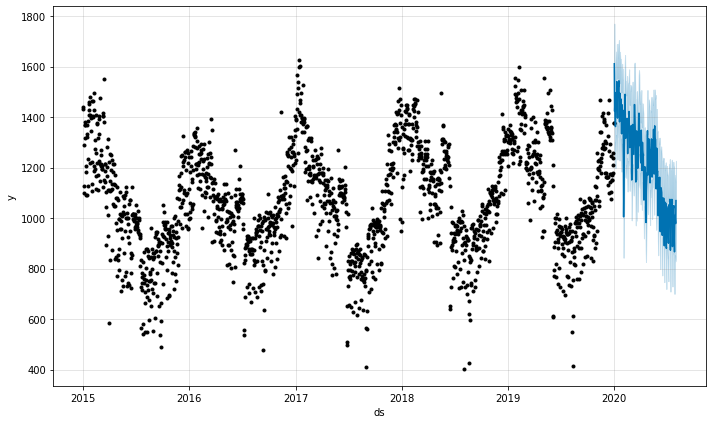

In [ ]:
fig=m.plot(forecast)


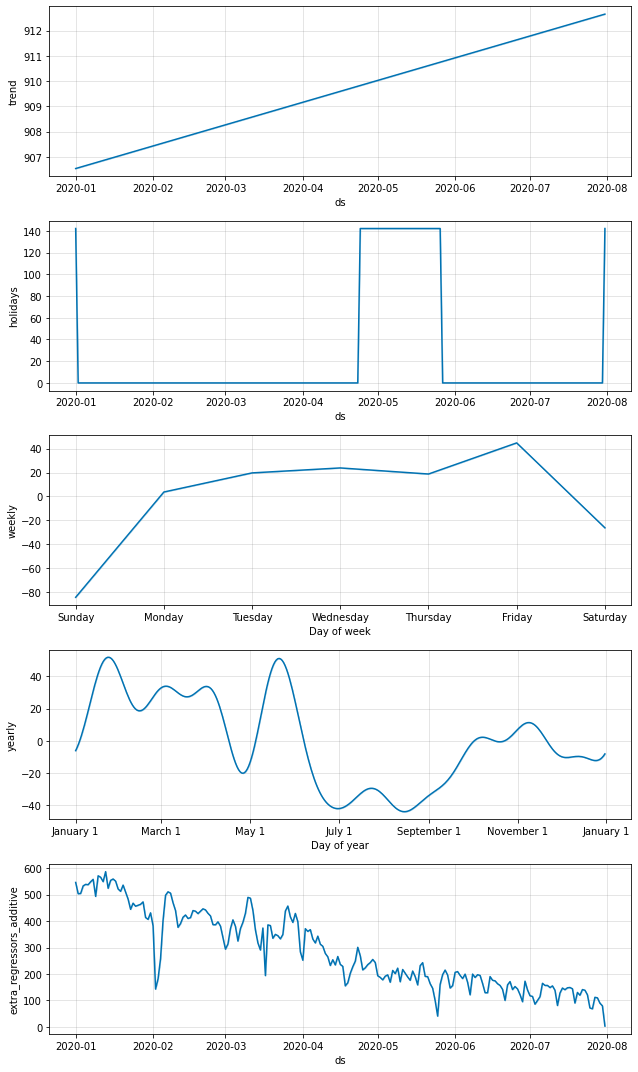

In [ ]:
fig2 = m.plot_components(forecast)

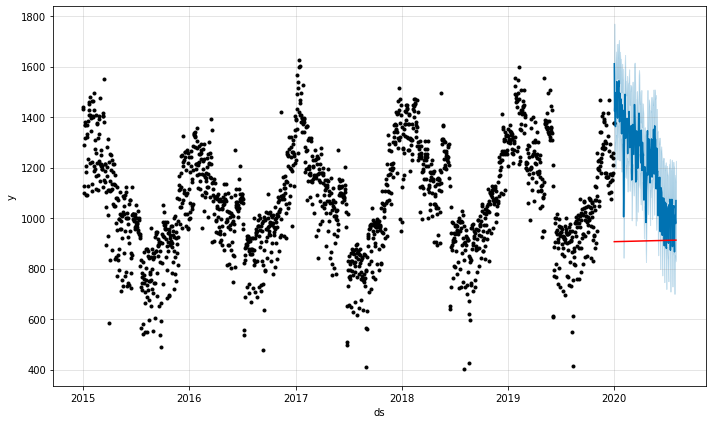

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(),m,forecast)
fig

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  def smape(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 2/y_true.shape[0]*np.sum(np.abs(y_true-y_pred))/np.sum((np.abs(y_true)+np.abs(y_pred)))*100
  def mase(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    naive_pred=y_true[1:]
    return 1/y_true.shape[0]*np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true[:len(y_true)-1]-naive_pred))*(y_true.shape[0]-1)
  #def owe(y_true,y_pred):
   # return (mase(y_true,y_pred)+smape(y_true,y_pred))/2

  print('Evaluation metric results:-')
  print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
  print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
  print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
  print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
  print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
  print('SMAPE is : '+str(smape(y_true,y_pred))+'\n')
  print('MASE is : '+str(mase(y_true,y_pred)))
  return

In [ ]:
from sklearn import metrics
import numpy as np

timeseries_evaluation_metrics_func(test['y'], forecast['yhat'])

Evaluation metric results:-
MSE is : 9687.121146840473
MAE is : 69.35124980732455
RMSE is : 98.42317383035599
MAPE is : 6.499815634896401 %
R2 is : 0.7493851802175393

SMAPE is : 0.026903929059678026

MASE is : 0.7986997478896569


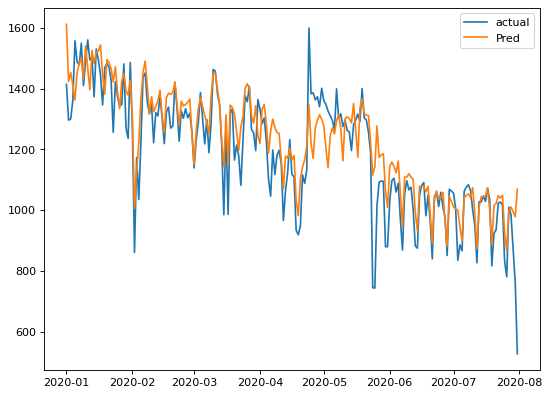

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(forecast['ds'],test['y'],label='actual')
plt.plot(forecast['ds'],forecast['yhat'],label='Pred')
plt.legend()
plt.show()

# peak period

In [ ]:
from sklearn import metrics
import numpy as np

timeseries_evaluation_metrics_func(test['y'][:90], forecast['yhat'][:90])

Evaluation metric results:-
MSE is : 6413.879420184961
MAE is : 59.959530150419674
RMSE is : 80.08669939624782
MAPE is : 4.768964088215312 %
R2 is : 0.617625424632197

SMAPE is : 0.04948715188685013

MASE is : 0.6032555034351517


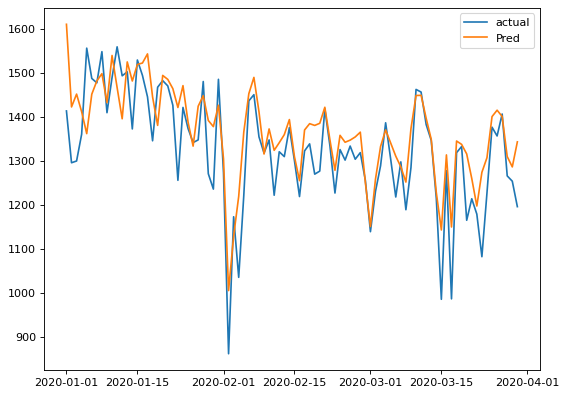

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(forecast['ds'][:90],test['y'][:90],label='actual')
plt.plot(forecast['ds'][:90],forecast['yhat'][:90],label='Pred')
plt.legend()
plt.show()